# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Loading Cleaned Data

In [ ]:
print("--- 1. Loading Cleaned Data ---")
try:
    # Loading the cleaned and imputed data from the first notebook
    df = pd.read_pickle('../data/cleaned_transactions.pkl')
    print(f"Cleaned data loaded successfully. Total rows: {len(df)}")
except FileNotFoundError:
    print("ERROR: Cleaned data not found. Please run 'notebooks/01_data_prep.ipynb' first.")
    exit()

# Display initial info to confirm data state
print("\n--- Cleaned DataFrame Info ---")
df.info()

--- 1. Loading Cleaned Data ---
Cleaned data loaded successfully. Total rows: 10200

--- Cleaned DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10200 entries, 0 to 10199
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   transaction_id             10200 non-null  object             
 1   customer_id                10200 non-null  object             
 2   timestamp                  10200 non-null  datetime64[ns, UTC]
 3   home_country               10200 non-null  category           
 4   source_currency            10200 non-null  category           
 5   dest_currency              10200 non-null  category           
 6   channel                    10200 non-null  category           
 7   amount_src                 10196 non-null  float64            
 8   amount_usd                 10200 non-null  float64            
 9   fee                   

# Exploratory Data Analysis (EDA)


--- 2. Exploratory Data Analysis (EDA) ---

2.1 Fraud Imbalance
Non-Fraud (0): 98.07%
Fraud (1): 1.93%

Observation: The dataset is highly imbalanced, requiring careful model evaluation (e.g., Precision, Recall) and potentially over/undersampling techniques in the modeling stage.

2.2 Transaction Amount Distribution (amount_usd)


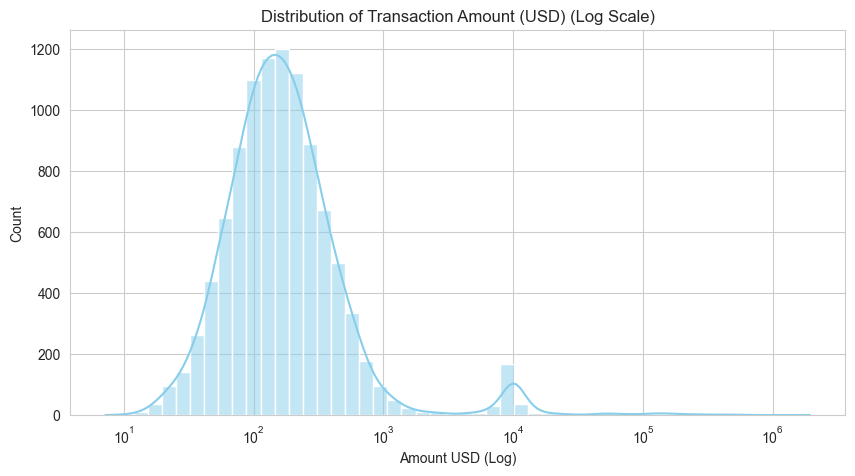


2.3 Fraudulent vs Non-Fraudulent Transaction Comparison


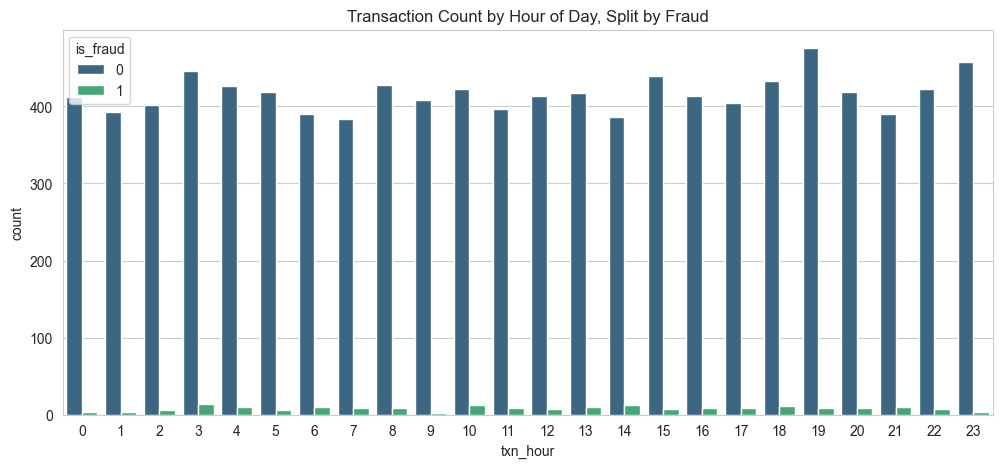

C:\Users\user\AppData\Local\Temp\ipykernel_11980\3119085755.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_fraud', y=col, data=df, palette='coolwarm')


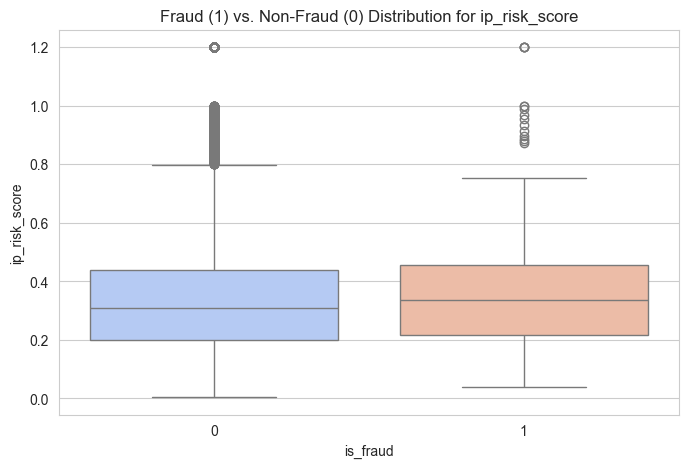

C:\Users\user\AppData\Local\Temp\ipykernel_11980\3119085755.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_fraud', y=col, data=df, palette='coolwarm')


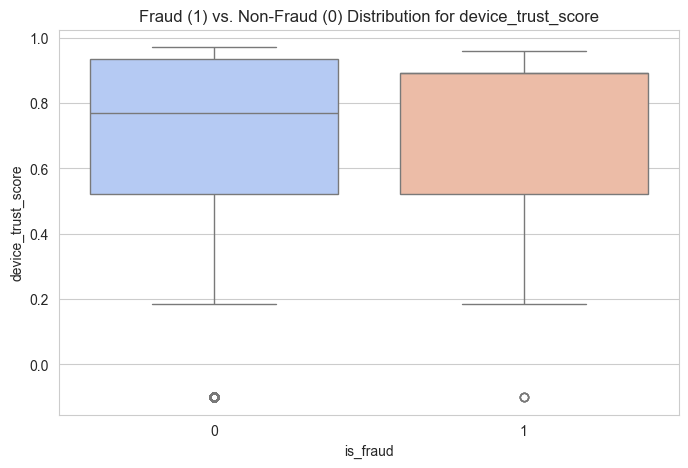

In [ ]:
print("\n--- 2. Exploratory Data Analysis (EDA) ---")

# 2.1 Class Imbalance Check 
print("\n2.1 Fraud Imbalance")
fraud_counts = df['is_fraud'].value_counts(normalize=True) * 100
print(f"Non-Fraud (0): {fraud_counts.iloc[0]:.2f}%")
print(f"Fraud (1): {fraud_counts.iloc[1]:.2f}%")
print("\nObservation: The dataset is highly imbalanced, requiring careful model evaluation (e.g., Precision, Recall) and potentially over/undersampling techniques in the modeling stage.")

# 2.2 Distribution of Transaction Amounts
print("\n2.2 Transaction Amount Distribution (amount_usd)")
plt.figure(figsize=(10, 5))
sns.histplot(df['amount_usd'], bins=50, kde=True, log_scale=True, color='skyblue')
plt.title('Distribution of Transaction Amount (USD) (Log Scale)')
plt.xlabel('Amount USD (Log)')
plt.show()

# 2.3 Fraudulent vs Non-Fraudulent Transaction Comparison
print("\n2.3 Fraudulent vs Non-Fraudulent Transaction Comparison")
# Time-based features: Txn Count by Hour
plt.figure(figsize=(12, 5))
sns.countplot(x='txn_hour', hue='is_fraud', data=df, palette='viridis')
plt.title('Transaction Count by Hour of Day, Split by Fraud')
plt.show()

# Risk Scores: Box plot comparison
risk_cols = ['ip_risk_score', 'device_trust_score']
for col in risk_cols:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='is_fraud', y=col, data=df, palette='coolwarm')
    plt.title(f'Fraud (1) vs. Non-Fraud (0) Distribution for {col}')
    plt.show()

# Feature Engineering: Behavioral and Velocity Features

In [ ]:
print("\n--- 3. Feature Engineering: Behavioral and Velocity Features ---")

# Sorting by customer and time is essential for calculating rolling/lag features
df.sort_values(by=['customer_id', 'timestamp'], inplace=True)

# Set 'timestamp' as the index for time-based rolling calculations
df = df.set_index('timestamp', drop=False)

# 3.1 Customer Transaction Velocity (Count)
# Rationale: Fraudsters often exhibit bursts of activity shortly after gaining access.
WINDOW_SIZE = '3D' # 3 Days
print(f"Calculating customer transaction count over a {WINDOW_SIZE} rolling window...")

# Group by customer_id
g = df.groupby('customer_id')

# Apply a rolling window calculation, excluding the current transaction (closed='left').
# By using the index (which is now 'timestamp'), Pandas correctly applies the '3D' window.
df['txn_count_prev_3d'] = (
    g['timestamp']
    .rolling(WINDOW_SIZE, closed='left')
    .count()
    .reset_index(level=0, drop=True) # Reset customer_id level, keeping original index
)

# Replace NaN (for first transaction in the time window) with 0
df['txn_count_prev_3d'] = df['txn_count_prev_3d'].fillna(0)
df['txn_count_prev_3d'] = df['txn_count_prev_3d'].astype(int)

# 3.2 Customer Mean Amount
# Rationale: A transaction amount significantly higher than a customer's personal average may indicate fraud.
print(f"\nCalculating customer mean amount over a {WINDOW_SIZE} rolling window...")

# Apply a rolling window calculation for the mean amount.
df['mean_amount_prev_3d'] = (
    g['amount_usd']
    .rolling(WINDOW_SIZE, closed='left')
    .mean()
    .reset_index(level=0, drop=True)
)

# Fill initial NaNs (for first transaction) with the global median to avoid information leakage
global_median_amount = df['amount_usd'].median()
df['mean_amount_prev_3d'] = df['mean_amount_prev_3d'].fillna(global_median_amount)

# 3.3 Flag for Unusual Transaction Size
# Rationale: Simple flag to detect transactions exceeding 2x the customer's recent mean.
df['is_high_amount_ratio'] = (df['amount_usd'] / df['mean_amount_prev_3d']) > 2.0 
df['is_high_amount_ratio'] = df['is_high_amount_ratio'].astype(int)


# 3.4 Velocity Ratio (Highly Predictive Feature)
# Rationale: A rapid increase in transaction velocity (high 1-hour rate relative to the 24-hour average) 
# is a strong indicator of an account takeover or fraud burst.
# Add 1 to the denominator to prevent division by zero for accounts with zero 24h transactions.
df["velocity_ratio"] = df["txn_velocity_1h"] / (df["txn_velocity_24h"] + 1)
print("\nVelocity features ('txn_count_prev_3d', 'mean_amount_prev_3d', 'is_high_amount_ratio', 'velocity_ratio') created successfully.")
print(df[['customer_id', 'timestamp', 'amount_usd', 'txn_count_prev_3d', 'velocity_ratio', 'is_fraud']].head(10))


--- 3. Feature Engineering: Behavioral and Velocity Features ---
Calculating customer transaction count over a 3D rolling window...

Calculating customer mean amount over a 3D rolling window...

Velocity features ('txn_count_prev_3d', 'mean_amount_prev_3d', 'is_high_amount_ratio', 'velocity_ratio') created successfully.
                                                           customer_id  \
timestamp                                                                
2023-10-31 15:18:49.468549+00:00  05e9b3f4-48d5-4f99-b5a5-8b55bbdeb4d2   
2023-01-27 23:03:01.468549+00:00  07581610-391c-4938-acf4-39c7c272fc39   
2023-02-14 04:09:38.468549+00:00  07581610-391c-4938-acf4-39c7c272fc39   
2023-04-22 11:52:08.468549+00:00  07581610-391c-4938-acf4-39c7c272fc39   
2023-07-02 05:31:31.468549+00:00  07581610-391c-4938-acf4-39c7c272fc39   
2023-07-02 05:31:31.468549+00:00  07581610-391c-4938-acf4-39c7c272fc39   
2023-10-10 03:02:07.468549+00:00  07581610-391c-4938-acf4-39c7c272fc39   
2023-10-10 

# Final Save

In [5]:
print("\n--- 4. Final Save ---")
# Drop the original 'timestamp' column as its information has been extracted into features, 
# and it is no longer needed for direct modeling (to avoid multicollinearity/redundancy).
# The timestamp column needs to be dropped from the index first, then dropped as a column.
df.reset_index(drop=True, inplace=True)
df_final = df.drop(columns=['timestamp'])

# Save the feature-engineered DataFrame for the modeling step
df_final.to_pickle('../data/feature_engineered_transactions.pkl')
print(f"Final feature-engineered DataFrame saved to '../data/feature_engineered_transactions.pkl'. Total columns: {len(df_final.columns)}")


--- 4. Final Save ---
Final feature-engineered DataFrame saved to '../data/feature_engineered_transactions.pkl'. Total columns: 36


### Summary

1. Robust Time-Based Aggregation (The "Velocity" Approach)
The core strength lies in using a rolling window, which is the most reliable way to calculate velocity features.

- Time-Windowed Lookback (WINDOW_SIZE = '3D'): By using a time-based offset ('3D') instead of a fixed number of rows, the feature accurately reflects the activity in the last 72 hours, regardless of how many transactions the customer made. This is essential for detecting a sudden burst of activity.

- Preventing Future Information Leakage (closed='left'): The closed='left' parameter is critical and correctly used. It ensures that the current transaction is excluded from its own rolling calculation. This prevents look-ahead bias and ensures the feature is realistic for a real-time prediction model.

2. Powerful Behavioral Indicators
The three resulting features are highly predictive in fraud detection:

- txn_count_prev_3d (Count): This directly measures the velocity of transactions. A high count suggests a potential "account takeover" (ATO) fraudster rushing to make transactions before the account is locked.

- mean_amount_prev_3d (Mean Amount): This establishes a baseline for the customer's typical transaction size. By comparing the current transaction to this recent average, you profile the customer's typical behavior.

- is_high_amount_ratio (Custom Threshold Flag): This is an excellent, engineered feature that combines the velocity mean with the current transaction amount. Flagging transactions that are 2x the recent mean acts as a simple, powerful rule-based feature layer for identifying outlier transactions that bypass the customer's standard spending habits.

3. Technical Stability and Best Practices (Fixes Implemented)
The latest version of the code demonstrates strong Pandas best practices:

- Correct Rolling Context: The step to use df = df.set_index('timestamp', drop=False) before grouping explicitly sets the datetime column as the index. This is the correct Pandas pattern for time-based rolling calculations on grouped data and fixed the initial ValueError.

- Avoiding Chained Assignment Warnings: Replacing the depreciated fillna(..., inplace=True) calls with df['col'] = df['col'].fillna(...) fixes potential FutureWarning issues and ensures code stability in future Pandas versions.

- Safe Imputation: Filling the initial NaN values (for the customer's first transaction within the window) with 0 for count and the global_median_amount for the mean is a safe and standard approach to prevent information leakage while ensuring the feature is always populated.